In [1]:
!pip install matplotlib scipy mpmath

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# Simple utilities
def imdisp(im):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

Loading image 3010...
Image loaded and resized.


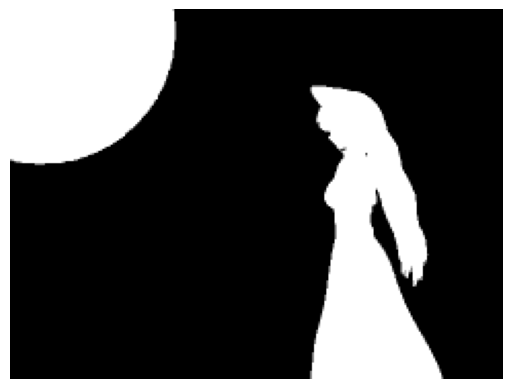

In [193]:
# Load image
def load_image(n):
    print(f"Loading image {n}...")
    image_gs = cv2.imread(f'frames/BadApple_{n}.jpg', cv2.IMREAD_GRAYSCALE)
    _, image = cv2.threshold(image_gs, 127 , 255, cv2.THRESH_BINARY)
    image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
    print("Image loaded and resized.")
    return image
image = load_image(3010)
imdisp(image)

Found 2 contours with lengths [269, 471].


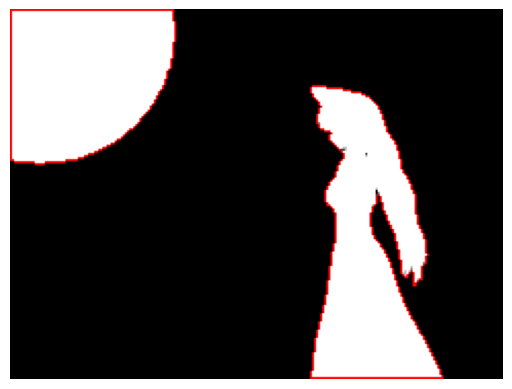

In [184]:
def get_contours(image):
    conts, hier = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    conts = [ i for i in conts if [0, 0] not in i or [179, 239] not in i ]
    athresh = 10
    conts = [ i for i in conts if cv2.contourArea(i) > athresh ]
    conts.sort(key=cv2.contourArea)
    print(f"Found {len(conts)} contours with lengths {[ len(i) for i in conts ]}.")
    return conts
conts = get_contours(image)
imdisp(cv2.drawContours(cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR), conts, -1, (0,0,255), 1))

In [443]:
deplsize = 40
def place_in_mosfet(xs, sd_depth=None, depl=None):
    deplr = [ 179 - depl - sd_depth for _ in range(deplsize + int(depl)) ]
    nodepl = [ 179 - sd_depth for _ in range(deplsize) ]
    result = deplr + xs + nodepl
    print(f"Depletion region added, total width {len(result)}")
    return result
def extract_from_mosfet(xs, depl=20):
    return xs[(deplsize+int(depl)):-deplsize]

In [445]:
def contour_to_lines(cont, **kwargs):
    contmap = {}
    print("Building contmap...")
    for [[x, y]] in cont:
        if x not in contmap:
            contmap[x] = []
        contmap[x].append(y)
    print("Done. ")
    print("Building rlines...")
    rlines = [{}, {}]
    entrance, exit = None, None
    for x, ys in contmap.items():
        # Entrance:
        if entrance is None:
            entrance = (x, max(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, max(ys))
        if entrance is None:
            entrances = (x, min(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, min(ys))
        # Exit:
        if exit is None:
            exit = (x, max(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, max(ys))
        if exit is None:
            exits = (x, min(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, min(ys))
        # Normal:
        rlines[0][x] = max(ys)
        rlines[1][x] = min(ys)
    print(f"Done, with entrance={entrance} and exit={exit}.")
    print("Building lines...")
    lines = [[], []]
    lasts = [ i for (_, i) in [entrance, entrance] ]
    for x in range(239):
        if x >= exit[0]:
            lines[0].append(179 - exit[1])
            lines[1].append(179 - exit[1])
            continue
        n1 = rlines[0].get(x, lasts[0])
        n2 = rlines[1].get(x, lasts[1])
        lines[0].append(179 - n1)
        lines[1].append(179 - n2)
        lasts[0] = n1
        lasts[1] = n2
    print("Done.")
    print("Building result (placing in mosfet)...")
    result = [ place_in_mosfet(i, **kwargs) for i in lines ]
    print("Done, all done with contour_to_lines.")
    return result

Building contmap...
Done. 
Building rlines...
Done, with entrance=(0, 73) and exit=(80, 15).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 339
Depletion region added, total width 339
Done, all done with contour_to_lines.
Building contmap...
Done. 
Building rlines...
Done, with entrance=(146, 179) and exit=(210, 179).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 339
Depletion region added, total width 339
Done, all done with contour_to_lines.
Plotting depletion region line...
Done.
Plotting depletion region line...
Done.
Plotting depletion region line...
Done.
Plotting depletion region line...
Done.


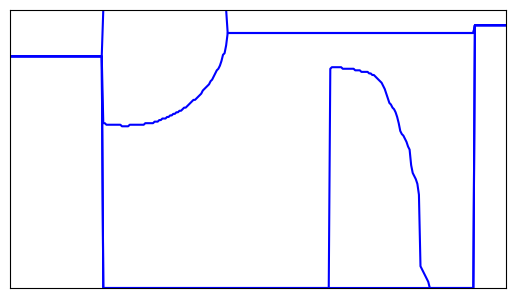

In [446]:
def plot_lines(conts, ax):
    ax.set_ylim((0, 179))
    ax.set_xlim((0, 319))
    ax.set_aspect(1)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    lines_list = [ contour_to_lines(cont, sd_depth=10, depl=20) for cont in conts ]
    for lines in lines_list:
        for line in lines:
            print("Plotting depletion region line...")
            plt.plot(line, color="blue")
            print("Done.")
    plt.show()
fig, ax = plt.subplots()
plot_lines(conts, ax)

I'm getting the values and calculation of $V_{FB}$ from [here](https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html).

In [418]:
# (not mine) Physical Constants:
e_0 = 8.854e-14 # Electric permittivity of free space (F cm^-1)
e = 1.602e-19 # Charge magnitude of an electron (C)
k = 8.617e-5 # Boltzmann's constant (eV / K)
# (not mine) Material Constants:
e_si = 11.7 # Relative electric permittivity of Silicon (dimensionless)
e_ox = 3.9 # Relative electric permittivity of SiO2 (dimensionless)
N_A = 1e17 # Acceptor doping concentration (cm^-3)
t_ox = 5e-6 # Oxide layer thickness (cm)
# (not mine) Material Constants used for calculating V_FB only:
chi_s = 4.17 # electron affinity, silicon (eV)
phi_m = 5.01 # work function, nickel (eV)
T = 300 # lattice temperature (K)
Eg = 1.17 - 4.73e-4 * T ** 2 / (T + 636.0) # bandgap, silicon (eV)
Nv = 3.5e15 * T ** 1.5 # effective valence band DOS, silicon (cm^-3)
Nc = 6.2e15 * T ** 1.5 # effective conduction band DOS, silicon, (cm^-3)
Nd = 1e16 # donor doping concentration (cm^-3)
Na, tox, e0, q, es = N_A, t_ox, e_0, e, e_si

In [419]:
# NOT MY CODE!!!!, SEE: https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html
# -----------------------
# dependent calculations
# -----------------------
from scipy.integrate import quad
# create smoothing functions
# - smoothly transitions to near-zero as f approaches zero
# - eps is the minimum value |f| reaches
def Sp(f, eps=1e-3):
    return (f + np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0
def Sn(f, eps=1e-3):
    return (f - np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0
def solve_bisection(func, target, xmin, xmax):
    # Returns the independent value x satisfying func(x)=value.
    # uses the bisection search method: https://en.wikipedia.org/wiki/Bisection_method
    tol = 1e-9 # when |a - b| <= tol, quit searching
    max_iters = 1e2 # maximum number of iterations
    a = xmin
    b = xmax
    cnt = 1
    Fa = target - func(a)
    c = a
    # bisection search loop
    while np.abs(a - b) > tol and cnt < max_iters:
        cnt += 1
        # make 'c' be the midpoint between 'a' and 'b'
        c = (a + b) / 2.0
        # calculate at the new 'c'
        Fc = target - func(c)

        if Fc == 0:
            # 'c' was the sought-after solution, so quit
            break
        elif np.sign(Fa) == np.sign(Fc):
            a = c # the signs were the same, so modify 'a'
            Fa = Fc # also update computed value
        else:
            b = c # the signs were different, so modify 'b'
    if cnt == max_iters:
        print('WARNING: max iterations reached')
    return c
# intrinsic carrier concentration, silicon, # / cm^3
ni = np.sqrt(Nc * Nv) * np.exp(-Eg / (2 * k * T))
# Energy levels are relative to one-another in charge expressions.
# - Therefore, it is OK to set Ev to a reference value of 0 eV.
# Usually, energy levels are given in Joules and one converts to eV.
# - I have just written each in eV to save time.
Ev = 0 # valence band energy level
Ec = Eg # conduction band energy level
Ei = k * T * np.log(ni / Nc) + Ec # intrinsic energy level
phit = k * T # thermal voltage, eV
# get the Fermi level in the bulk where there is no band-bending
n = lambda Ef: Nc * np.exp((-Ec + Ef) / phit)
p = lambda Ef: Nv * np.exp((Ev - Ef) / phit)
func = lambda Ef: p(Ef) - n(Ef) + Nd - Na
Ef = solve_bisection(func, 0, Ev, Ec)
# compute semiconductor work function (energy from vacuum to Ef)
phi_s = chi_s + Ec - Ef
# flatband voltage and its constituent(s)
# - no defect-related charges considered
phi_ms = phi_m - phi_s # metal-semiconductor workfunction, eV
V_FB = phi_ms # flatband voltage, V
print(f"V_FB = {V_FB}")
# ^^^ NOT MY CODE, SEE: https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html (end of not my code)

V_FB = -0.14728591344484965


In [these slides](https://inst.eecs.berkeley.edu/~ee105/sp08/lectures/lecture15_2.pdf), we find the following equation:
$$X_d = \frac{\varepsilon_{Si}}{C_{ox}}\left[\sqrt{1 + \frac{2C_{ox}^2(V_{G} - V_{FB})}{q \varepsilon_{Si} N_A}} - 1\right]$$
We know that $C_{ox} = \varepsilon_{ox} \varepsilon_0 / t_{ox}$, allowing us to make it:
$$X_d = \frac{\varepsilon_{Si} t_{ox}}{\varepsilon_{ox} \varepsilon_0}\left[\sqrt{1 + \frac{2(\frac{\varepsilon_{ox} \varepsilon_0}{t_{ox}})^2(V_{G} - V_{FB})}{q \varepsilon_{Si} N_A}} - 1\right]$$

Finally, we can break this up into some constants to make it easier to work with:
$$X_d = k_1\left(\sqrt{1+k_2(V_G-V_{FB})}-1\right)$$
Where:
$$k_1 = \frac{\varepsilon_{Si} t_{ox}}{\varepsilon_{ox} \varepsilon_0}$$
$$k_2 = \frac{2(\frac{\varepsilon_{ox} \varepsilon_0}{t_{ox}})^2}{q \varepsilon_{Si} N_A}$$
or:
$$k_2 = \frac{2(\varepsilon_{ox} \varepsilon_0)^2}{t_{ox}^2 q \varepsilon_{Si} N_A}$$
However, since $k_2$ is usually very small, we can approximate $\sqrt{1 + x} - 1$ as $x / 2$, since $x$ here will be very close to zero.
Thus, we get can form a single constant $k_X$, defined as:
$$k_X = \frac{\varepsilon_{ox} \varepsilon_0}{t_{ox} q N_A}$$.
such that:
$$X_d = k_X (V_G - V_{FB})$$

In [333]:
k_X = (e_ox * e_0) / (t_ox * e * N_A)
print("Parameters for Depletion Region Depth:")
print("V_FB = " + repr(V_FB))
print("k_X = " + repr(k_X))

Parameters for Depletion Region Depth:
V_FB = -0.14728591344484965
k_X = 4.310936329588014e-06


Now, we need to determine the threshold voltage $V_{TH}$. Above this, the MOSFET will be an inverted state, where current can flow and a channel is formed. For the Bad Apple part, this will be the maximum voltage, which will in turn determine the scale for the actual depletion layer visualization. First, we need to know the workfunction of bulk p-type \[100\] silicon $\phi_B$. This was obtained [here](https://onlinelibrary.wiley.com/doi/10.1002/eem2.12218). The fact that \[100\] crystallographic direction is used was determined [here](http://transport.ece.illinois.edu/ECE340S14-Lectures/ECE340Lecture34-MOS_CapII-Dist.pdf). 

In [334]:
# One last material constant:
phi_b = 4.85 # work function, (bulk, p-type) silicon (doping doesn't actually affect it much) (eV)

With this, we can use the following equation from [here](https://www.chu.berkeley.edu/wp-content/uploads/2020/01/Chenming-Hu_ch5-1.pdf) that describes the threshold voltage $V_{TH}$:
$$V_{TH} = V_{FB} + 2\phi_B + \frac{\sqrt{4q\varepsilon_{Si}N_A\phi_B}}{C_{ox}}$$
Expanding out $C_{ox}$ and simplifying, we get:
$$V_{TH} = V_{FB} + 2\phi_B + \frac{t_{ox} \sqrt{2q\varepsilon_{Si}N_A\phi_B}}{\varepsilon_{ox}\varepsilon_0}$$

In [335]:
threshvoltage_finaln = t_ox * ((2 * e * e_si * N_A * phi_b) ** 0.5)
threshvoltage_finald = e_ox
V_TH = V_FB + (2 * phi_b) + (threshvoltage_finaln / threshvoltage_finald)
print("Threshold Voltage:")
print("V_TH = " + repr(V_TH))

Threshold Voltage:
V_TH = 9.552715815238507


In [336]:
from mpmath import mpf
import mpmath
mpmath.mp.dps = 50
def xd_from_vg(V_G):
    return k_X * (V_G - V_FB)
def vg_from_xd(X_d):
    return (X_d / k_X) + V_FB

In [337]:
# We need to calculate the maximum depletion region depth, as this is what is created by the threshold voltage
X_dMAX = xd_from_vg(V_TH)
print(f"X_dMAX = {X_dMAX}")
print(f"X_dMAX (in nm) = {X_dMAX * 1e7}")

X_dMAX = 4.1816089849247624e-05
X_dMAX (in nm) = 418.16089849247624


In [386]:
# We have to draw everything at the proper scale...
def nm_to_shown(nm):
    frac = nm / (X_dMAX * 1e7)
    return frac * 179

In [393]:
# Now that we know the scale we can actually calculate the depth of the source and drain terminals
actual_sd_depth = nm_to_shown(100)
print(f"Depth of source and drain [actual_sd_depth] (nm) = {actual_sd_depth}")

Depth of source and drain [actual_sd_depth] (nm) = 42.806489235439756


In [368]:
# We also need to calculate the size of the ordinary P-N depletion layers around the source and drain
def pn_depletion_region_nm(V):
    x_n = (2 * e_si * e_0 * Na * V) / (e * Nd * (Na + Nd))
    x_n **= 0.5
    y_n = (2 * e_si * e_0 * Nd * V) / (e * Na * (Nd + Na))
    y_n **= 0.5
    return (x_n + y_n) * 1e7
depl_width_drain = pn_depletion_region_nm(0.001) # We'll set up a 1mV difference between the drain and the body
# The source will be tied to the body (it doesn't really matter and you usually ground the source anyway). 
print("Depletion width @ source (nm) = 0")
print(f"Depletion width @ drain (nm) = {depl_width_drain}")

Depletion width @ source (nm) = 0
Depletion width @ drain (nm) = 11.927317337792456


(0.0, 0.0, 0.0, 1.0)


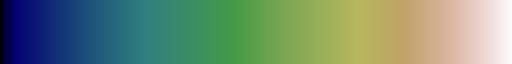

In [381]:
from matplotlib import colormaps as cmaps
import matplotlib.patches as mpatch
chosen_cmap = cmaps["gist_earth"]
print(chosen_cmap(0))
chosen_cmap

In [403]:
def annotate_rect(ax, rect, rect_text, **kwargs):
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2
    cy = ry + rect.get_height() / 2
    ax.annotate(rect_text, (cx, cy), ha="center", va="center", **kwargs)

Loading image 3010...
Image loaded and resized.
Found 2 contours with lengths [269, 471].
Building contmap...
Done. 
Building rlines...
Done, with entrance=(0, 73) and exit=(80, 15).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 330
Depletion region added, total width 330
Done, all done with contour_to_lines.
Building contmap...
Done. 
Building rlines...
Done, with entrance=(146, 179) and exit=(210, 179).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 330
Depletion region added, total width 330
Done, all done with contour_to_lines.
Oxide height (shown) = 21.40324461771988
Height above substrate (shown) = 31.40324461771988
Reconfiguring depletion regions plot...
Done reconfiguring depletion regions plot.
Drawing line on voltages plot...
Drawing line on depletion regions plot...
Depletion region added, total width 330
Done drawing line.
Drawing line on voltages plot...
Drawing line on

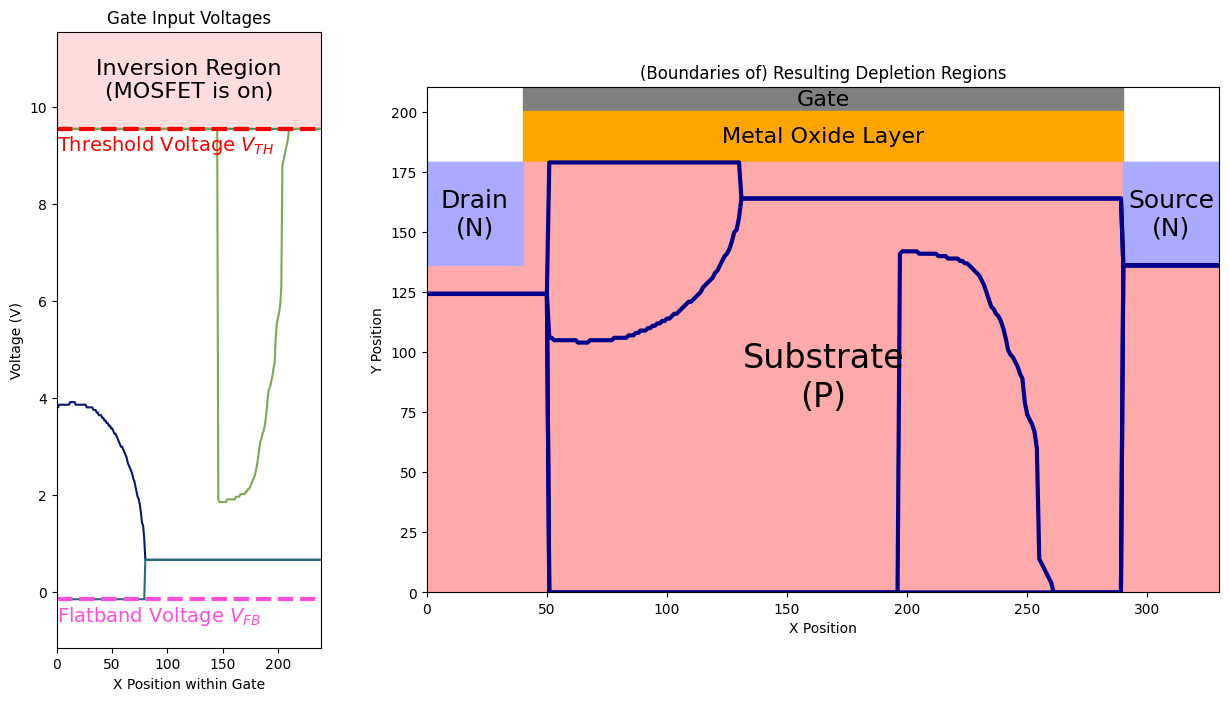

In [481]:
###### Finally, we get to put it together!
deplregion_boundary_color = "darkblue"
def plot_frame(n):
    def make_vg(segm):
        return vg_from_xd((1 - (segm / 179)) * X_dMAX)
    def xd_from_vg_in_mosfet(vg):
        X_d = xd_from_vg(vg)
        X_d *= 179 / X_dMAX
        X_d = 179 - X_d
        return X_d
    image = load_image(n)
    conts = get_contours(image)
    lines_list = [ contour_to_lines(i, sd_depth=actual_sd_depth, depl=depl_width_drain) for i in conts ]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={"width_ratios": [1, 3]})
    n_colors = 6
    colors = [ chosen_cmap((i / n_colors) + (1 / 16)) for i in range(int(n_colors * (7 / 8))) ]
    colors.extend(reversed(colors))
    color_i = 0
    bufh = 1
    # For ax2:
    shown_gate_height = 10
    shown_oxide_height = nm_to_shown(t_ox * 1e7)
    shown_above_substrate = shown_oxide_height + shown_gate_height
    print(f"Oxide height (shown) = {shown_oxide_height}")
    print(f"Height above substrate (shown) = {shown_above_substrate}")
    print("Reconfiguring depletion regions plot...")
    ax2.set_aspect(1) # MIGHT WANT TO ADJUST THIS
    ax2.set_title("(Boundaries of) Resulting Depletion Regions")
    gate = mpatch.Rectangle((deplsize, 179 + shown_oxide_height), 330 - (2 * deplsize), shown_gate_height, color="gray")
    ax2.add_artist(gate)
    annotate_rect(ax2, gate, "Gate", color="black", fontsize=16)
    oxide = mpatch.Rectangle((deplsize, 179), 330 - (2 * deplsize), shown_oxide_height, color="orange")
    ax2.add_artist(oxide)
    annotate_rect(ax2, oxide, "Metal Oxide Layer", color="black", fontsize=16)
    # For ax2: source (N), drain (N), and substrate (P)
    ptype_color, ntype_color = "#FFAAAA", "#AAAAFF"
    p = mpatch.Rectangle((0, 0), 330, 179, color=ptype_color)
    ax2.add_artist(p)
    annotate_rect(ax2, p, "Substrate\n(P)", color="black", fontsize=24)
    n1 = mpatch.Rectangle((0, 179 - actual_sd_depth), deplsize, actual_sd_depth, color=ntype_color)
    ax2.add_artist(n1)
    annotate_rect(ax2, n1, "Drain\n(N)", color="black", fontsize=18)
    n2 = mpatch.Rectangle((330 - deplsize, 179 - actual_sd_depth), deplsize, actual_sd_depth, color=ntype_color)
    ax2.add_artist(n2)
    annotate_rect(ax2, n2, "Source\n(N)", color="black", fontsize=18)
    # For ax2: labels and axis limits
    ax2.set_xlim((0, 330))
    ax2.set_ylim((0, 179 + shown_above_substrate))
    ax2.set_xlabel("X Position")
    ax2.set_ylabel("Y Position")
    print("Done reconfiguring depletion regions plot.")
    for lines in lines_list:
        for line in lines:
            # For ax1:
            print("Drawing line on voltages plot...")
            line_inner = extract_from_mosfet(line, depl=depl_width_drain)
            Y_pot = np.vectorize(make_vg)(line_inner)
            X_pot = np.array(range(len(Y_pot)))
            ax1.plot(X_pot, Y_pot, color=colors[color_i])
            color_i += 1
            color_i %= len(colors)
            print("Drawing line on depletion regions plot...")
            # For ax2:
            Y_depl = np.vectorize(xd_from_vg_in_mosfet)(list(Y_pot))
            Y_depl = place_in_mosfet(list(Y_depl), sd_depth=actual_sd_depth, depl=depl_width_drain)
            X_depl = np.array(range(len(Y_depl)))
            ax2.plot(X_depl, Y_depl, color=deplregion_boundary_color, linewidth=3)
            print("Done drawing line.")
    # For ax1:
    print("Reconfiguring voltages plot...")
    ax1.axhline(V_FB, color="#FE4EDA", linestyle="--", linewidth=3)
    ax1.axhline(V_TH, color="red", linestyle="--", linewidth=3)
    ax1.set_title("Gate Input Voltages")
    ax1.set_xlabel("X Position within Gate")
    ax1.set_ylabel("Voltage (V)")
    ax1.text(-0.1, V_TH - 0.25 - 0.2, "Threshold Voltage $V_{TH}$", color="red", size=14)
    ax1.text(-0.1, V_FB - 0.25 - 0.2, "Flatband Voltage $V_{FB}$", color="#FE4EDA", size=14)
    rect = mpatch.Rectangle((0, V_TH), 239, 2 * bufh, color="#FFDDDD")
    ax1.add_artist(rect)
    rect_text = "Inversion Region\n(MOSFET is on)"
    annotate_rect(ax1, rect, rect_text, color="black", fontsize=16)
    ax1.set_xlim((0, 239))
    ax1.set_ylim((V_FB - bufh, V_TH + (2 * bufh)))
    print("Done reconfiguring voltages plot.")
    print("All done, plots are ready.")
    return fig
plot_frame(3010)
plt.show()

In [485]:
def process_frame(n):
    fig = plot_frame(n)
    plt.savefig(f"outframes/BadAppleMOSFET_{n}.jpg")
    plt.close(fig)

In [486]:
# Just to test
process_frame(3010)

Loading image 3010...
Image loaded and resized.
Found 2 contours with lengths [269, 471].
Building contmap...
Done. 
Building rlines...
Done, with entrance=(0, 73) and exit=(80, 15).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 330
Depletion region added, total width 330
Done, all done with contour_to_lines.
Building contmap...
Done. 
Building rlines...
Done, with entrance=(146, 179) and exit=(210, 179).
Building lines...
Done.
Building result (placing in mosfet)...
Depletion region added, total width 330
Depletion region added, total width 330
Done, all done with contour_to_lines.
Oxide height (shown) = 21.40324461771988
Height above substrate (shown) = 31.40324461771988
Reconfiguring depletion regions plot...
Done reconfiguring depletion regions plot.
Drawing line on voltages plot...
Drawing line on depletion regions plot...
Depletion region added, total width 330
Done drawing line.
Drawing line on voltages plot...
Drawing line on

In [483]:
# THIS CODE RUNS THROUGH EVERY FRAME AND WILL PROBABLY TAKE AGES
# IF THIS IS NOT WHAT YOU INTEND TO DO, YOU HAVE BEEN WARNED
for n in range(1, 6572):
    print(f"Processing frame {n}...")
    process_frame(n)
    print("Done processing a frame.")
print("All done. :)")

NameError: name 'process_frame' is not defined